# Deep Learning Framework for Predicting Himalayan Summit Success 


## 0. Setup

The following section of the notebook covers all relevant imports required for the project. 

In [ ]:
# The following code is only for Google Collab whenever wanting to perform runs there
# !git clone https://github.com/Aaron-Serpilin/DeepSummit.git
# !pip install --upgrade pip
# !pip install -e .
# %cd DeepSummit
# %ls

In [1]:
from torch import nn
from torchvision import transforms

try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 2.+"
    assert int(torchvision.__version__.split(".")[1]) >= 15, "torchvision version should be 0.15+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not correct. Installing correct versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

try:
    import matplotlib.pyplot as plt
except ImportError:
    print("[INFO] Couldn't find matplotlib...installing it")
    !pip install -q matplotlib
    import matplotlib.pyplot as plt

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from tqdm.auto import tqdm
except:
    print(f"[INFO] Couldnt't find tqdm... installing it ")
    !pip install tqdm
    from tqdm.auto import tqdm

try:
    from torchinfo import summary
except ImportError:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from dbfread import DBF
except ImportError:
    print("[INFO] Coudln't find dbfread...installing it")
    !pip install -q dbfread
    from dbfread import DBF


try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter

try:
    import torchmetrics, mlxtend
    print(f"mlextend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >- 19
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlextend version: {mlxtend.__version__}")

try:
    import cdsapi
except ImportError:
    print("[INFO] Coudldn't find cdsapi...installing it.")
    !pip install -q cdsapi
    import cdsapi

try:
    import pandas as pd
except ImportError:
    print("[INFO] Couldn't find pandas... installing it")
    !pip install -q pandas
    import pandas as pd

try:
    from einops import rearrange, repeat
except ImportError:
    print("[INFO] Couldn't find einops... installing it")
    !pip install -q einops
    from einops import rearrange, repeat

try:
    import pygrib
except ImportError:
    print("[INFO] Couldn't find pygrib... installing it")
    !pip install -q pygrib
    import pygrib


torch version: 2.6.0
torchvision version: 0.21.0


/Users/aaronserpilin/anaconda3/envs/Python3_Env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mlextend version: 0.23.4


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Himalayan Data Setup

The following section covers the retrieval and processing of the tabular data from the Himalayan Database that will use the SAINT architecture to carry out inference. The raw data was obtained through the `get_data.py` file. 

In [3]:
# We adjust the PYTHONPATH to keep absolute imports
import sys
sys.path.append("src")

In [4]:
from pathlib import Path

himalayan_train_dir = Path("data/himalayas_data/train")
himalayan_val_dir = Path("data/himalayas_data/val")
himalayan_test_dir = Path("data/himalayas_data/test")

himalayan_train_file = himalayan_train_dir / "train.csv"
himalayan_val_file = himalayan_val_dir / "val.csv"
himalayan_test_file = himalayan_test_dir / "test.csv"

In [5]:
df_train = pd.read_csv(himalayan_train_file)

print(f"First 10 rows:\n{df_train.head(10)}")
print(f"First training instance:\n{df_train.iloc[0]}")
print(f"Instance shape:\n{df_train.iloc[0].shape}")

First 10 rows:
  SEX      CITIZEN      STATUS  MO2USED  MROUTE1  SEASON  O2USED  CALCAGE  \
0   M        Japan     Climber     True        1       3    True       49   
1   M        Spain     Climber    False        1       3   False       54   
2   F  Switzerland     Climber    False        1       3    True       25   
3   M        Nepal  H-A Worker     True        1       1    True       31   
4   M          USA     Climber     True        1       1    True       60   
5   M      Bahrain     Climber    False        1       3    True       34   
6   M        Chile     Climber     True        1       1    True       42   
7   F        Japan      Leader     True        0       4    True       43   
8   M        India     Climber     True        1       1    True       48   
9   M      S Korea     Climber    False        0       3   False       29   

   HEIGHTM  MDEATHS  HDEATHS  SMTMEMBERS  SMTHIRED  Target  
0     8163        0        0          14        11       1  
1     8163     

The `load_himalayan_data()` function defined within the `tab_data_setup` file transforms the raw data from .DBF to .csv, filters the relevant features, filters the relevant peaks, develops a data frame with this data, and then creates the corresponding train, val, and test splits by using the `create_dataloaders()` helper function.

In [6]:
from src.tab_transformer.tab_data_setup import load_himalayas_data

tab_df = load_himalayas_data(do_prepare=True, do_finalize=True)
output_path = Path('data/himalayas_data')
output_file = output_path / "himalayas_data.csv"
tab_df.to_csv(output_file, index=False)

print(tab_df.shape)
print(tab_df.head)

(53102, 19)
<bound method NDFrame.head of            EXPID PEAKID MEMBID SEX  CALCAGE    CITIZEN         STATUS  \
5      ANN169101   ANN1     01   M       34  W Germany         Leader   
6      ANN169101   ANN1     02   M       39  W Germany  Deputy Leader   
7      ANN169101   ANN1     05   M       32  W Germany        Climber   
8      ANN169101   ANN1     03   M       30  W Germany        Climber   
9      ANN169101   ANN1     04   M       28  W Germany        Climber   
...          ...    ...    ...  ..      ...        ...            ...   
54325  MAKA24106   MAKA     02   F       35    Ukraine        Climber   
54326  MAKA24106   MAKA     03   M       38      India        Climber   
54327  MAKA24106   MAKA     04   M       39      India        Climber   
54328  MAKA24106   MAKA     05   F       49      China        Climber   
54329  MAKA24106   MAKA     06   M       27      Nepal     H-A Worker   

       MO2USED  MROUTE1     SMTDATE  SEASON  SMTMEMBERS  SMTHIRED  MDEATHS  \
5  

In [10]:
import os
from pathlib import Path
from src.helper_functions import set_seeds, set_data_splits, create_dataloaders
from src.tab_transformer.tab_utils import TabularDataset

set_seeds(42)

splits_path = Path("data/himalayas_data")
tab_csv = splits_path / "himalayas_data.csv"
tab_df = pd.read_csv(tab_csv, parse_dates=["SMTDATE"])

categorical_columns = ['SEX', 'CITIZEN', 'STATUS', 'MO2USED', 'MROUTE1', 'SEASON', 'O2USED']
continuous_columns = ['CALCAGE', 'HEIGHTM', 'MDEATHS', 'HDEATHS', 'SMTMEMBERS', 'SMTHIRED']
feature_columns = categorical_columns + continuous_columns

X = tab_df[feature_columns]
y = tab_df["Target"]

set_data_splits(X, y, splits_path, seed=42)

continuous_means = [tab_df[col].mean() for col in continuous_columns]
continuous_stds = [tab_df[col].std() for col in continuous_columns]
continuous_mean_std = list(zip(continuous_means, continuous_stds))

train_dataloader, val_dataloader, test_dataloader = create_dataloaders(
        dataset_class=TabularDataset,
        train_file=splits_path / "train" / "train.csv",
        val_file=splits_path / "val" / "val.csv",
        test_file=splits_path / "test" / "test.csv",
        num_workers=os.cpu_count(),
        batch_size=32,
        dataset_kwargs={
            'target_column': 'Target',
            'cat_cols': categorical_columns,
            'continuous_mean_std': continuous_mean_std,
        }
    )

train_dataloader, val_dataloader, test_dataloader

[INFO] Data splits already exist under data/himalayas_data. Skipping split.


(<torch.utils.data.dataloader.DataLoader at 0x16c631690>,
 <torch.utils.data.dataloader.DataLoader at 0x16c666e10>)

## 2. SAINT Model instantiation

The following section instantiates the SAINT model architecture based on the hyperparameter selection defined in the relevant paper. This is broken down in the `tab_breakdown.ipynb` file where the core equations and backbone of the architecture is explained. 

In [7]:
cat_batch, cont_batch, label_batch, cat_mask_batch, cont_mask_batch = next(iter(train_dataloader))

# First instance
cat_instance = cat_batch[0]
cont_instance = cont_batch[0]
label_instance = label_batch[0]

print(f"Categorical instance: {cat_instance}\nCategorical instance shape: {cat_instance.shape}\n")
print(f"Continuous instance: {cont_instance}\nContinuous instance shape: {cont_instance.shape}\n")
print(f"Label instance: {label_instance}\nLabel instance shape: {label_instance.shape}\n")

Categorical instance: tensor([  0,   1, 147,  60,   0,   1,   2,   0])
Categorical instance shape: torch.Size([8])

Continuous instance: tensor([ 0.2272, -1.1185, -0.2801, -0.1664, -0.8072, -0.6175])
Continuous instance shape: torch.Size([6])

Label instance: 0
Label instance shape: torch.Size([])



In [ ]:
from src.tab_transformer.tab_model import SAINT
import numpy as np

categorical_columns = ['SEX', 'CITIZEN', 'STATUS', 'MO2USED', 'MROUTE1', 'SEASON', 'O2USED']
continuous_columns = ['CALCAGE', 'HEIGHTM', 'MDEATHS', 'HDEATHS', 'SMTMEMBERS', 'SMTHIRED']

# Returns the amount of unique values per categorical column
cat_dims = [len(np.unique(df_train[col])) for col in categorical_columns]

# Hyperparameter selection based on default original architecture instantiation
saint = SAINT(
    categories = tuple(cat_dims), 
    num_continuous = len(continuous_columns),                
    dim = 32,                           
    dim_out = 1,                       
    depth = 6,                       
    heads = 8,  
    num_special_tokens=1,                      
    attn_dropout = 0.1,             
    ff_dropout = 0.1,                  
    mlp_hidden_mults = (4, 2),       
    cont_embeddings = 'MLP',
    attentiontype = 'colrow',
    final_mlp_style = 'sep',
    y_dim = 2 # Binary classification
)

saint.to(device)

## 3. SAINT Model Training

The following section trains the SAINT model with the `TabularDataset` class while saving the corresponding files in the `runs` directory using the `SummaryWriter()` setup.

In [10]:
from src.tab_transformer.tab_train import train_step, test_step

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(saint.parameters(),lr=0.0001, betas=(0.9, 0.999), weight_decay=0.01)

train_step(model=saint,
           dataloader=train_dataloader,
           loss_fn=loss_fn,
           optimizer=optimizer,
           device=device
)

val_step = test_step(model=saint,
                     dataloader=val_dataloader,
                     loss_fn=loss_fn,
                     device=device)

val_step

(0.0005769020462610636, 0.9054718875502008)

In [ ]:
writer = SummaryWriter()

In [ ]:
%%time
from helper_functions import set_seeds
from src.tab_transformer.tab_train import train
from helper_functions import create_writer

set_seeds(42)


results = train(model=saint,
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=10,
      writer=create_writer(experiment_name="first_run",
                                   model_name="saint")
)

[INFO] Created SummaryWriter, saving to: runs/2025-05-20--13:22:21/first_run/saint


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [04:53<44:03, 293.68s/it]

Epoch: 1 | train_loss: 0.1896 | train_acc: 0.9240 | val_loss: 0.0005 | val_acc: 0.9119 | test_loss: 0.0008 | test_acc: 0.9175


 20%|██        | 2/10 [09:53<39:39, 297.40s/it]

Epoch: 2 | train_loss: 0.1838 | train_acc: 0.9259 | val_loss: 0.0005 | val_acc: 0.9130 | test_loss: 0.0008 | test_acc: 0.9155


 30%|███       | 3/10 [15:05<35:27, 303.96s/it]

Epoch: 3 | train_loss: 0.1840 | train_acc: 0.9262 | val_loss: 0.0006 | val_acc: 0.9096 | test_loss: 0.0009 | test_acc: 0.9166


 40%|████      | 4/10 [19:53<29:45, 297.53s/it]

Epoch: 4 | train_loss: 0.1785 | train_acc: 0.9300 | val_loss: 0.0006 | val_acc: 0.8979 | test_loss: 0.0010 | test_acc: 0.9051


 50%|█████     | 5/10 [24:43<24:35, 295.08s/it]

Epoch: 5 | train_loss: 0.1757 | train_acc: 0.9298 | val_loss: 0.0008 | val_acc: 0.9132 | test_loss: 0.0010 | test_acc: 0.9168


 60%|██████    | 6/10 [29:10<19:01, 285.43s/it]

Epoch: 6 | train_loss: 0.1746 | train_acc: 0.9300 | val_loss: 0.0006 | val_acc: 0.9130 | test_loss: 0.0009 | test_acc: 0.9130


 70%|███████   | 7/10 [33:36<13:57, 279.07s/it]

Epoch: 7 | train_loss: 0.1715 | train_acc: 0.9317 | val_loss: 0.0005 | val_acc: 0.9083 | test_loss: 0.0009 | test_acc: 0.9100


 80%|████████  | 8/10 [38:03<09:10, 275.31s/it]

Epoch: 8 | train_loss: 0.1656 | train_acc: 0.9335 | val_loss: 0.0006 | val_acc: 0.9034 | test_loss: 0.0009 | test_acc: 0.9015


 90%|█████████ | 9/10 [42:38<04:35, 275.28s/it]

Epoch: 9 | train_loss: 0.1631 | train_acc: 0.9344 | val_loss: 0.0003 | val_acc: 0.9083 | test_loss: 0.0012 | test_acc: 0.9013


100%|██████████| 10/10 [47:16<00:00, 283.61s/it]

Epoch: 10 | train_loss: 0.1607 | train_acc: 0.9348 | val_loss: 0.0002 | val_acc: 0.9136 | test_loss: 0.0010 | test_acc: 0.9104
CPU times: user 1h 37min 20s, sys: 27min 35s, total: 2h 4min 56s
Wall time: 47min 16s


With a `test_acc` of ~91%, the SAINT Model architecture achieves better results than the benchmark Regression model from the Julia project. Therefore, prior to fine tuning the model, and without the incorporation of contextual meteorological data, the model already has a better performance than the baseline. 

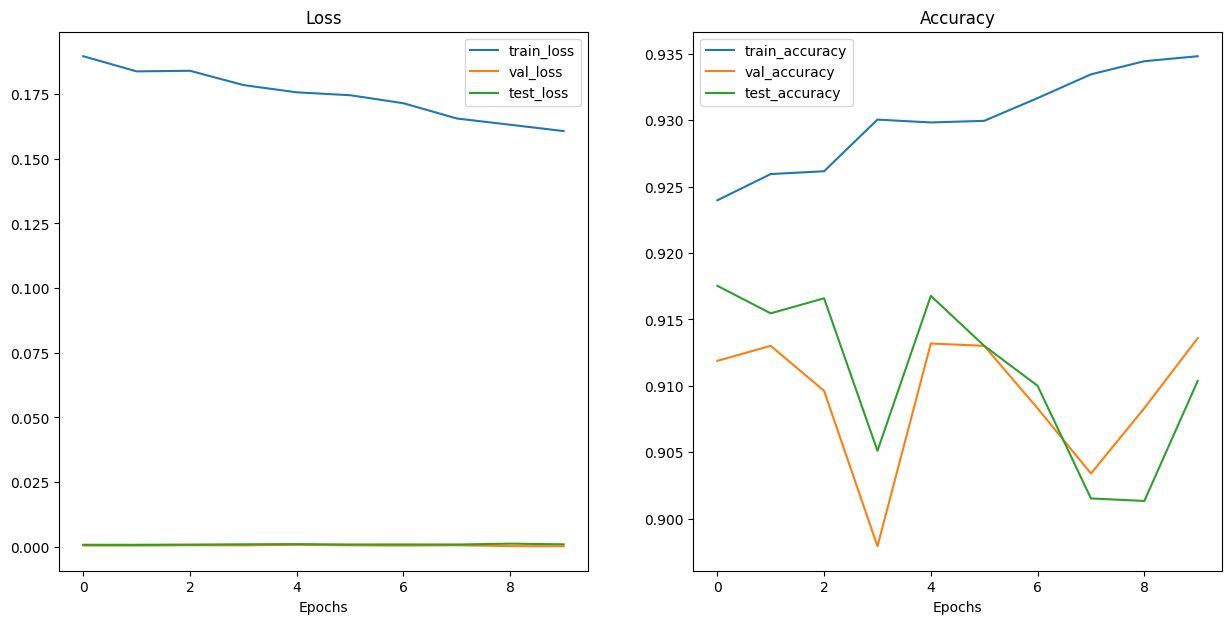

In [14]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 4. Era5 Data Setup

The following section covers the data preparation of the era5 dataset. The raw data was obtained through the `get_data.py` file. 

The entire data setup from the era5 dataset is condensed into the `load_era5_data` function, which does multiple things. 

Firstly, it uses`file_to_grib()` to convert all the raw era5 files into .grib files, which facilitate it for processing afterwards. 

This is followed by `get_variable_mapping()` which obtains the corresponding mapping of the internal grib abbreviations and the actual features from the era5 dataset. This is used to then filter out the desired features when we transform the .grib file into a .csv file. 

For convenience, we can run `get_variable_mapping()` each time, but in this study case the mapping doesn't change every time. Therefore, we can store the result of the first run in a variable and then merely refer to it, which saves up ~3 minutes of runtime.  

This mapping is this passed as a parameter to `process_grib_to_csv()` to filter out the desired features and convert the .grib files to .csv, storing them in `data/era5_data/instances/raw_instances`.

Afterwards, due to the API request limitations, the original requests in `get_data.py` were done in batches of 5 years, leading to each mountain to have 17 different weather data files. Therefore, in order to condense them, we then use `merge_daily_instances()` which condenses all of these files into a single .csv file in `data/era5_data/instances/merged_instances`. 

The final step of the function is to then use `build_event_instances()` to create the final ML table by the weather and tabular data are matched based on their `date` and `peakid`. It then creates the instances with the target variable from the tabular dataset, and also adds the relevant 7-day context window to analyze the weather trends that affect summit probabilities. 

In [5]:
from src.met_transformer.met_data_setup import load_era5_data

weather_df = load_era5_data(do_build_instances=True, n_context_days=7)
output_path = Path('data/era5_data')
output_file = output_path / "era5_data.csv"
weather_df.to_csv(output_file, index=False)

print(weather_df.shape)
print(weather_df.head)

[Skipping] Incomplete window for KANG on 1929-05-27 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-05-18 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-05-18 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-05-18 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-05-18 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-05-18 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-05-18 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-05-06 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-05-06 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-05-06 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-05-06 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-05-06 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-05-06 00:00:00: 0 days
[Skipping] Incomplete window for MAKA on 1990-06-11 00:00:00: 0 days
[Skipping] Incomplete window for M

The original tabular dataset had 53102 rows. However, when creating the new weather dataset by joining the tabular instances, we now have 52638 rows, and 444 features. The reason for the drop in the rows is because of our 7-day context. Whenever there were instances where there was not sufficient context days, said instances were dropped. 

For reference, due to the significant amount of columns and rows, below is the file size for the complete weather data:

In [9]:
from pathlib import Path

era5_data_csv_size = Path("data/era5_data/era5_data.csv").stat().st_size // (1024*1024)
print(f"Complete era5 weather data file size: {era5_data_csv_size} MB")

Complete era5 weather data file size: 421 MB


## 5. Stormer Model Instantiation

When initializing the Stormer model, we pass it an extensive list of variables. However, according to research, not all variables have the same influence on weather patterns. Pressure, temperature, and wind have been consistently identified as major weather drivers. Therefore, while the model itself can increase the weight of these parameters as it identifies that the target is more significantly predicted by these, we aim at saving time and increase performance by providing said weights with a boost to signal their more relevant importance. 

Hence, we can identify which are the most relevant features and then develop a mask to signal priority, while also providing a weight boost.

Consequently, due to this weight initialization, we shall later incorporate regularization (either spare or bounded) to help prevent over-reliance on any one of these weather variables. 

In [6]:
weather_mapping = {
    '10u':   '10 metre U wind component',
    '10v':   '10 metre V wind component',
    '2d':    '2 metre dewpoint temperature',
    '2t':    '2 metre temperature',
    'msl':   'Mean sea level pressure',
    'sp':    'Surface pressure',
    'tp':    'Total precipitation',
    'istl1': 'Ice temperature layer 1',
    'istl2': 'Ice temperature layer 2',
    'istl3': 'Ice temperature layer 3',
    'istl4': 'Ice temperature layer 4',
    'mx2t':  'Maximum temperature at 2 metres since previous post-processing',
    'mn2t':  'Minimum temperature at 2 metres since previous post-processing',
    'skt':   'Skin temperature',
    '100u':  '100 metre U wind component',
    '100v':  '100 metre V wind component',
    'u10n':  '10 metre u-component of neutral wind',
    'v10n':  '10 metre v-component of neutral wind',
    '10fg':  'Maximum 10 metre wind gust since previous post-processing',
    'i10fg': 'Instantaneous 10 metre wind gust',
    'cbh':   'Cloud base height',
    'hcc':   'High cloud cover',
    'lcc':   'Low cloud cover',
    'mcc':   'Medium cloud cover',
    'tcc':   'Total cloud cover',
    'tciw':  'Total column cloud ice water',
    'tclw':  'Total column cloud liquid water',
    'viiwd': 'Vertical integral of divergence of cloud frozen water flux',
    'vilwd': 'Vertical integral of divergence of cloud liquid water flux',
    'viiwe': 'Vertical integral of eastward cloud frozen water flux',
    'vilwe': 'Vertical integral of eastward cloud liquid water flux',
    'viiwn': 'Vertical integral of northward cloud frozen water flux',
    'vilwn': 'Vertical integral of northward cloud liquid water flux',
    'cp':    'Convective precipitation',
    'crr':   'Convective rain rate',
    'ilspf': 'Instantaneous large-scale surface precipitation fraction',
    'lsrr':  'Large scale rain rate',
    'lsp':   'Large-scale precipitation',
    'lspf':  'Large-scale precipitation fraction',
    'mxtpr': 'Maximum total precipitation rate since previous post-processing',
    'mntpr': 'Minimum total precipitation rate since previous post-processing',
    'ptype': 'Precipitation type',
    'tcrw':  'Total column rain water',
    'csf':   'Convective snowfall',
    'csfr':  'Convective snowfall rate water equivalent',
    'lssfr': 'Large scale snowfall rate water equivalent',
    'lsf':   'Large-scale snowfall',
    'asn':   'Snow albedo',
    'rsn':   'Snow density',
    'sd':    'Snow depth',
    'es':    'Snow evaporation',
    'sf':    'Snowfall',
    'smlt':  'Snowmelt',
    'tsn':   'Temperature of snow layer',
    'tcsw':  'Total column snow water'
}

The following array are all the meteorological variables requested from the era5 API, and that will be used to instantiate Stormer. 

In [8]:
variables = [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "2m_dewpoint_temperature",
        "2m_temperature",
        "mean_sea_level_pressure",
        "surface_pressure",
        "total_precipitation",
        "ice_temperature_layer_1",
        "ice_temperature_layer_2",
        "ice_temperature_layer_3",
        "ice_temperature_layer_4",
        "maximum_2m_temperature_since_previous_post_processing",
        "minimum_2m_temperature_since_previous_post_processing",
        "skin_temperature",
        "100m_u_component_of_wind",
        "100m_v_component_of_wind",
        "10m_u_component_of_neutral_wind",
        "10m_v_component_of_neutral_wind",
        "10m_wind_gust_since_previous_post_processing",
        "instantaneous_10m_wind_gust",
        "cloud_base_height",
        "high_cloud_cover",
        "low_cloud_cover",
        "medium_cloud_cover",
        "total_cloud_cover",
        "total_column_cloud_ice_water",
        "total_column_cloud_liquid_water",
        "vertical_integral_of_divergence_of_cloud_frozen_water_flux",
        "vertical_integral_of_divergence_of_cloud_liquid_water_flux",
        "vertical_integral_of_eastward_cloud_frozen_water_flux",
        "vertical_integral_of_eastward_cloud_liquid_water_flux",
        "vertical_integral_of_northward_cloud_frozen_water_flux",
        "vertical_integral_of_northward_cloud_liquid_water_flux",
        "convective_precipitation",
        "convective_rain_rate",
        "instantaneous_large_scale_surface_precipitation_fraction",
        "large_scale_rain_rate",
        "large_scale_precipitation",
        "large_scale_precipitation_fraction",
        "maximum_total_precipitation_rate_since_previous_post_processing",
        "minimum_total_precipitation_rate_since_previous_post_processing",
        "precipitation_type",
        "total_column_rain_water",
        "convective_snowfall",
        "convective_snowfall_rate_water_equivalent",
        "large_scale_snowfall_rate_water_equivalent",
        "large_scale_snowfall",
        "snow_albedo",
        "snow_density",
        "snow_depth",
        "snow_evaporation",
        "snowfall",
        "snowmelt",
        "temperature_of_snow_layer",
        "total_column_snow_water"
    ]

In [10]:
met_weights = {
    key: 1.2 # an 20% boost to these key weights
    for key, description in weather_mapping.items()
    if any(term in description.lower() for term in ("wind", "temperature", "pressure"))
}

priority_features = [key for key in met_weights]

Following the creation of the appropriate .csv file for training purposes, we can now leverage `set_splits()` and `create_dataloaders()` to instantiate our splits and dataloaders. 

In [11]:
from pathlib import Path
from src.helper_functions import set_seeds, set_data_splits, create_dataloaders
from src.met_transformer.met_utils import WeatherDataset

set_seeds(42)

splits_path = Path("data/era5_data")
weather_csv = Path("data/era5_data/era5_data.csv")
weather_df = pd.read_csv(weather_csv, parse_dates=["event_date"])

metadata_cols = ["PEAKID", "parent_peakid", "event_date"]
X = weather_df.drop(columns=["Target"])
y = weather_df["Target"]

set_data_splits(X, y, splits_path, seed=42)

weather_train_dataloader, weather_val_dataloader, weather_test_dataloader = create_dataloaders(
    dataset_class=WeatherDataset,
    train_file=splits_path / "train" / "train.csv",
    val_file=splits_path / "val" / "val.csv",
    test_file=splits_path / "test" / "test.csv",
    batch_size=32,
    dataset_kwargs={
        'target_column': 'Target',
        'metadata_cols': metadata_cols,
        'continuous_mean_std': None,
        'priority_features':  priority_features,
        'variables': variables
    }

)

weather_train_dataloader, weather_val_dataloader, weather_test_dataloader

[INFO] Data splits already exist under data/era5_data. Skipping split.


(<torch.utils.data.dataloader.DataLoader at 0x3b0ba8f90>,
 <torch.utils.data.dataloader.DataLoader at 0x31f2b6d50>)

In [ ]:
X_batch, mask_batch, y_batch, window_batch = next(iter(weather_train_dataloader))

print(f"X:{X_batch}\nmask: {mask_batch}\ny: {y_batch}\nwindow_batch: {window_batch}\n")

In [ ]:
# First instance
X_instance = X_batch[0]
mask_instance = mask_batch[0]
y_instance = y_batch[0]
window_instance = window_batch[0]

print(f"X: {X_instance}\nmask: {mask_instance}\ny: {y_instance}\nwindow: {window_instance}\n")

When assigning initial weights to certain variables due to their greater significance, one can use the `weather_mapping` used above, which was obtained from the `met_data_setup.py` file that has the internal feature mapping used by the `.csv` file due to its creation using `pygrib`. Such mapping lacks however the offsets which are added below. When instantiating the `FeatureWeatherEmbedding` class in `met_model.py`, one can refer to this mapping to select the desired variables and assign the right weights. 

In [12]:
offsets= range(0, 8)
met_weights_with_offset = {
    f"{feat}_t-{off}":weight
    for feat, weight in met_weights.items()
    for off in offsets
}

When initializing the Stormer model, we pass it an extensive list of variables. However, according to research, not all variables have the same influence on weather patterns. Pressure, temperature, and wind have been consistently identified as major weather drivers. Therefore, while the model itself can increase the weight of these parameters as it identifies that the target is more significantly predicted by these, we aim at saving time and increase performance by providing said weights with a boost to signal their more relevant importance. 

Consequently, due to this weight initialization, we shall later incorporate regularization (either spare or bounded) to help prevent over-reliance on any one of these weather variables. 

In [13]:
from src.met_transformer.met_model import Stormer

stormer = Stormer(img_size=[128, 256],
                  variables=variables,
                  met_weights=met_weights_with_offset,
                  patch_size=2,
                  hidden_size=1024,
                  depth=24,
                  num_heads=16,
                  mlp_ratio=4.0)

stormer.to(device)

Stormer(
  (embedding): FeaturedWeightedEmbedding(
    (proj): Linear(in_features=55, out_features=1024, bias=True)
  )
  (embed_norm_layer): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=False)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=False)
      (mlp): MLP(
        (mlp): Sequential(
          (0): Linear(in_features=1024, out_features=8192, bias=True)
          (1): GLU()
          (2): Swish()
          (3): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (adaLN_modulation): Sequential(
        (0): Swish()
        (1): Linear(in_feature

## 6. Stormer Model training

In [ ]:
from src.met_transformer.met_train import train_step, test_step

# Hyperparameters pulled from the paper
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(stormer.parameters(),lr=3e-4, betas=(0.9, 0.999), weight_decay=1e-2)

train_step(model=stormer,
           dataloader=weather_train_dataloader,
           loss_fn=loss_fn,
           optimizer=optimizer,
           device=device,
           lambda_reg=1e-3
)

val_step = test_step(model=saint,
                     dataloader=weather_val_dataloader,
                     loss_fn=loss_fn,
                     device=device)

val_step

Although we have the training code here, due to the size of Stormer and the massive dataset, it is unfeasible to train it on Google Collab due to memory limitations. The training of the model was actually done on the DAS5 supercomputer.

In [ ]:
%%time
from helper_functions import set_seeds, create_writer
from src.tab_transformer.tab_train import train

set_seeds(42)

stormer_results = train(model=stormer,
      train_dataloader=weather_train_dataloader,
      val_dataloader=weather_val_dataloader,
      test_dataloader=weather_test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=75,
      writer=create_writer(experiment_name="first_run",
                                   model_name="stormer")
)

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(stormer_results)

## 7. DeepSummit Model

Following the development of the SAINT and Stormer models, we merge both through late fusion to develop the DeepSummit model which leverages both the TabularDataset and WeatherDataset to develop a more comprehensive prediction. 